# Bioseq Autoencoder Prototype

This notebook prototypes an autoencoder as a proof of concept for denoising genomic sequences.
The denoising is achieved by training the autoencoder on noisy $k$-mers, where $k$ is a parameter that defines the length of the $k$-mers.
Denoising can be helpful in genome assembly processes, especially since the input data may contain *single nucleotide polymorphisms*, which are single base changes, or sequencing errors.

In the context of De-Bruijn graph construction, the autoencoder can denoise $k$-mers before graph assembly, reducing bubbles and improving overall assembly quality.
Bubbles (structures in a De-Bruijn graph formed by divergent and convergent paths between the same nodes) are caused by sequencing errors or heterozygosity.
This is resulting in local graph ambiguities that hinder accurate genome assembly, due to disrupting the formation of Eulerian paths.
This could also help in identifying true low-frequency variants, such as somatic mutations in cancer genomes.

This is a thesis proposal, however, not a full thesis proposal.
It is a first step towards understanding where current research may be heading.

In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__, torch.version.cuda, torch.backends.cudnn.version(), device)

2.8.0+cu126 12.6 91002 cuda


 Firstly, I will download a FASTA file containing the _Escherichia coli K-12 MG1655_ genome from NCBI.
The file is compressed in _gzip_ format, so I will use the `gzip` module to read it.
The `Bio.SeqIO` module from Biopython will be used to parse the FASTA file.

In [3]:
import gzip
from Bio import SeqIO

import urllib.request

url = "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/005/845/GCF_000005845.2_ASM584v2/GCF_000005845.2_ASM584v2_genomic.fna.gz"
urllib.request.urlretrieve(url, "ecoli.fna.gz")

with gzip.open("ecoli.fna.gz", "rt") as handle:
    records = list(SeqIO.parse(handle, "fasta"))

print(f"number of sequences: {len(records)}")
print(f"first record ID: {records[0].id}")
print(f"length: {len(records[0].seq)} bases")
print(f"first 100 nucleotides:\n{records[0].seq[:100]}")

number of sequences: 1
first record ID: NC_000913.3
length: 4641652 bases
first 100 nucleotides:
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


Secondly, I will define functions to extract $k$-mers from the sequence and add salt-and-pepper-ish noise to the sequence.

In [4]:
def get_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def add_noise(sequence, noise_level=0.1):
    noisy = list(sequence)
    for i in range(len(sequence)):
        if random.random() < noise_level:
            noisy[i] = random.choice([n for n in "ACGT" if n != sequence[i]])
    return "".join(noisy)

I will define functions to convert $k$-mers into one-hot encoded tensors.
Each nucleotide will be represented as a vector of length $4$, where the position corresponding to the nucleotide is set to `1` and all other positions are set to `0`.

In [5]:
def one_hot(kmer):
    mapping = {"A": [1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    return torch.tensor(np.array([mapping[nucleotide] for nucleotide in kmer]), dtype=torch.float32)

def one_hot_batch(kmers):
    return torch.stack([one_hot(kmer) for kmer in kmers])

Next, I will extract $k$-mers from the first record in the FASTA file and create a noisy version of the sequence.
I set $k = 31$, which is a common choice for genomic sequences.
After that, I will create an $X\%$-subset of the $k$-mers for training and validation.
I will call this the _f_-phase (flooding phase) (you may observe the RAM utilisation during execution to see why).

In [6]:
k = 31
sequence = str(records[0].seq)
noisy_sequence = add_noise(sequence)

clean_kmers = get_kmers(sequence, k)
noisy_kmers = get_kmers(noisy_sequence, k)

subset_fraction = 0.8
total_kmers = len(clean_kmers)
subset_size = int(subset_fraction * total_kmers)

subset_indices = np.random.choice(total_kmers, size=subset_size, replace=False)

x_clean_subset = one_hot_batch([clean_kmers[i] for i in subset_indices])
x_noisy_subset = one_hot_batch([noisy_kmers[i] for i in subset_indices])
x_clean_train, x_clean_val, x_noisy_train, x_noisy_val = train_test_split(
    x_clean_subset, x_noisy_subset, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(x_noisy_train, x_clean_train)
val_dataset = TensorDataset(x_noisy_val, x_clean_val)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Now, I will define the autoencoder model for $k$-mers.

In [7]:
class KMerAutoenc(nn.Module):
    def __init__(self, k, embedding_dim=64):
        super().__init__()
        self.k = k
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(k * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, k * 4)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(-1, self.k, 4)
        return out

Why don't we create an instance of the model and define the loss function and optimiser?

In [8]:
model = KMerAutoenc(k).to(device)
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

I am using the `MSELoss` loss function.
As a quality metric, I will use the Hamming distance between the predicted and target $k$-mers.

In [9]:
def hamming_distance(output, target):
    pred = output.argmax(dim=2)
    true = target.argmax(dim=2)
    return (pred != true).float().mean().item()

def hamming_quality(hamming):
    if hamming <= 0.05:
        return "very good"
    elif hamming <= 0.2:
        return "acceptable"
    elif hamming <= 0.5:
        return "poor"
    else:
        return "terrible"

def train(model, train_loader, val_loader, optimiser, criterion, epochs=10):
    train_losses, val_losses, train_hamming, val_hamming = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        running_ham = 0
        for x_noisy, x_clean in train_loader:
            x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
            optimiser.zero_grad()
            output = model(x_noisy)
            loss = criterion(output, x_clean)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * x_noisy.size(0)
            running_ham += hamming_distance(output, x_clean) * x_noisy.size(0)

        train_loss_epoch = running_loss / len(train_loader.dataset)
        train_ham_epoch = running_ham / len(train_loader.dataset)
        train_losses.append(train_loss_epoch)
        train_hamming.append(train_ham_epoch)

        model.eval()
        val_loss_total = 0
        val_ham_total = 0
        with torch.no_grad():
            for x_noisy, x_clean in val_loader:
                x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
                val_output = model(x_noisy)
                val_loss_total += criterion(val_output, x_clean).item() * x_noisy.size(0)
                val_ham_total += hamming_distance(val_output, x_clean) * x_noisy.size(0)

        val_loss_epoch = val_loss_total / len(val_loader.dataset)
        val_ham_epoch = val_ham_total / len(val_loader.dataset)
        val_losses.append(val_loss_epoch)
        val_hamming.append(val_ham_epoch)

        print(f"epoch {epoch+1}/{epochs} | "
              f"train loss: {train_loss_epoch:.4f} | val loss: {val_loss_epoch:.4f} | "
              f"train hamming: {train_ham_epoch:.4f} ({hamming_quality(train_ham_epoch)}) | "
              f"val hamming: {val_ham_epoch:.4f} ({hamming_quality(val_ham_epoch)})")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), train_losses, label='train loss')
    plt.plot(range(1, epochs+1), val_losses, label='val loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), train_hamming, label='train hamming')
    plt.plot(range(1, epochs+1), val_hamming, label='val hamming')
    plt.xlabel('epoch'); plt.ylabel('hamming distance'); plt.title('hamming distance'); plt.legend()
    plt.tight_layout()
    plt.show()


plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

Let's train the model.

epoch 1/12 | train loss: 0.2422 | val loss: 0.2154 | train hamming: 0.1498 (acceptable) | val hamming: 0.1195 (acceptable)
epoch 2/12 | train loss: 0.1999 | val loss: 0.1994 | train hamming: 0.1013 (acceptable) | val hamming: 0.1008 (acceptable)
epoch 3/12 | train loss: 0.1972 | val loss: 0.1969 | train hamming: 0.1008 (acceptable) | val hamming: 0.1007 (acceptable)
epoch 4/12 | train loss: 0.1950 | val loss: 0.2010 | train hamming: 0.1005 (acceptable) | val hamming: 0.1056 (acceptable)
epoch 5/12 | train loss: 0.1931 | val loss: 0.1977 | train hamming: 0.1004 (acceptable) | val hamming: 0.1040 (acceptable)
epoch 6/12 | train loss: 0.1918 | val loss: 0.1916 | train hamming: 0.1003 (acceptable) | val hamming: 0.1004 (acceptable)
epoch 7/12 | train loss: 0.1909 | val loss: 0.1914 | train hamming: 0.1003 (acceptable) | val hamming: 0.1006 (acceptable)
epoch 8/12 | train loss: 0.1902 | val loss: 0.1938 | train hamming: 0.1004 (acceptable) | val hamming: 0.1038 (acceptable)
epoch 9/12 | tra

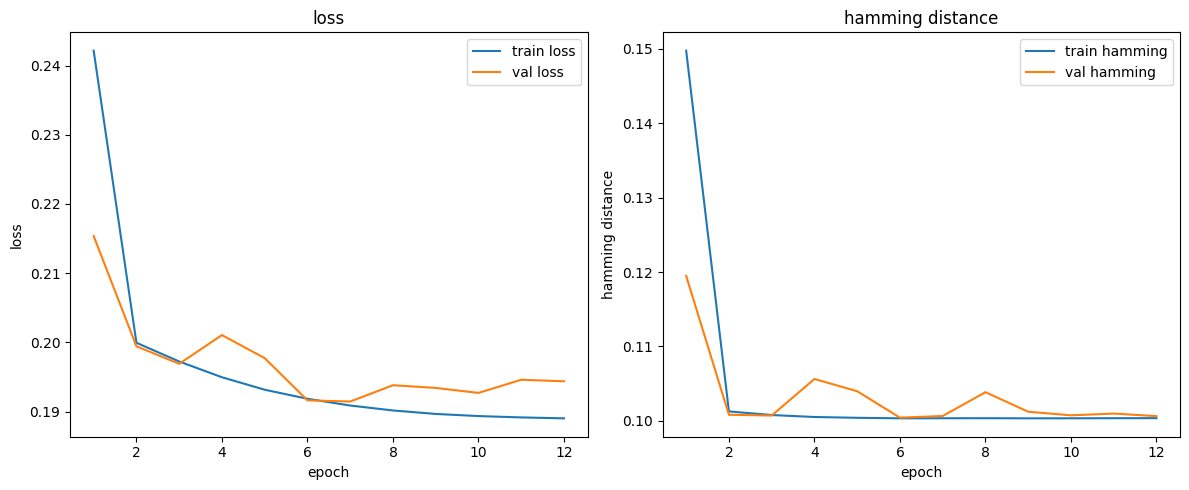

In [10]:
train(model, train_loader, val_loader, optimiser, criterion, epochs=12)


To suffice the proof of concept, the model should regard multiple variants of the same $k$-mer.
Or more specific in regard to the thesis topic proposal, multiple variants of a more complex genome, including low-frequency somatic mutations.